In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.impute import  SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline


In [2]:
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

In [3]:
def plot_mi_scores(scores):
    scores = scores.sort_values()
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("MI Scores")
    plt.show()

In [4]:
data = pd.read_csv('data/lab1_data.csv')

map_gender = {'Male' : 0, 'Female' : 1}
data['gender'] = data['gender'].map(map_gender)

In [5]:
bin_fill = [ 'smoker', 'family_history', 'gender', 'alcohol']
other_fill = [col for col in data.columns if col not in bin_fill+['disease_risk', 'id', ]]

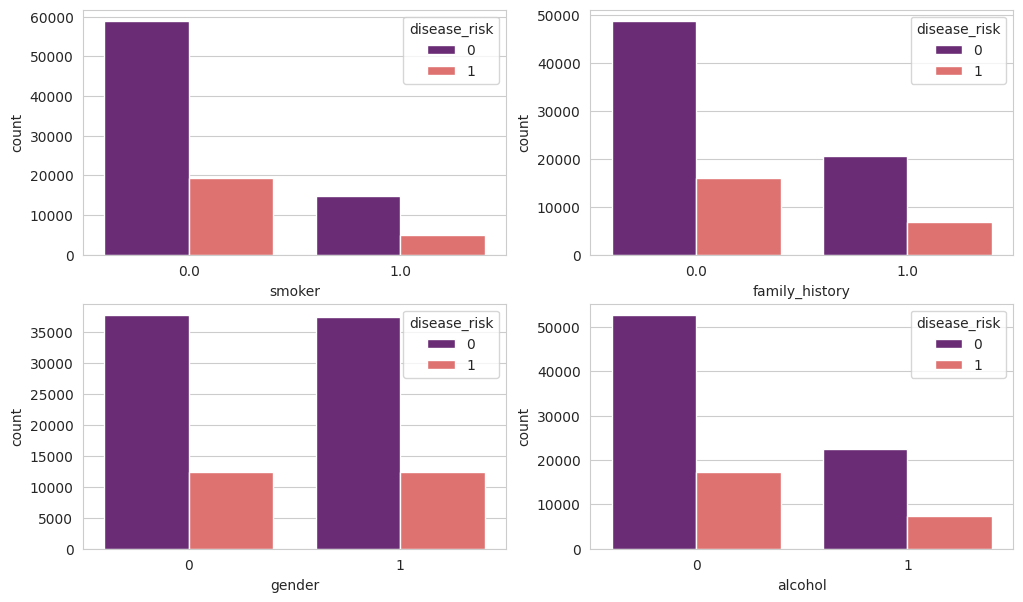

In [6]:
fig, axs = plt.subplots(2,2, figsize=(12,7))

for i, ax in enumerate(axs.flat):
  sns.countplot(x=data[bin_fill[i]], hue=data['disease_risk'],  palette = 'magma', ax = ax)

plt.show()

In [7]:
for col in (bin_fill):
  print(pd.crosstab(data[col], data['disease_risk']), '\n')

disease_risk      0      1
smoker                    
0.0           58839  19371
1.0           14753   4906 

disease_risk        0      1
family_history              
0.0             48656  15959
1.0             20687   6894 

disease_risk      0      1
gender                    
0             37731  12401
1             37448  12420 

disease_risk      0      1
alcohol                   
0             52634  17364
1             22545   7457 



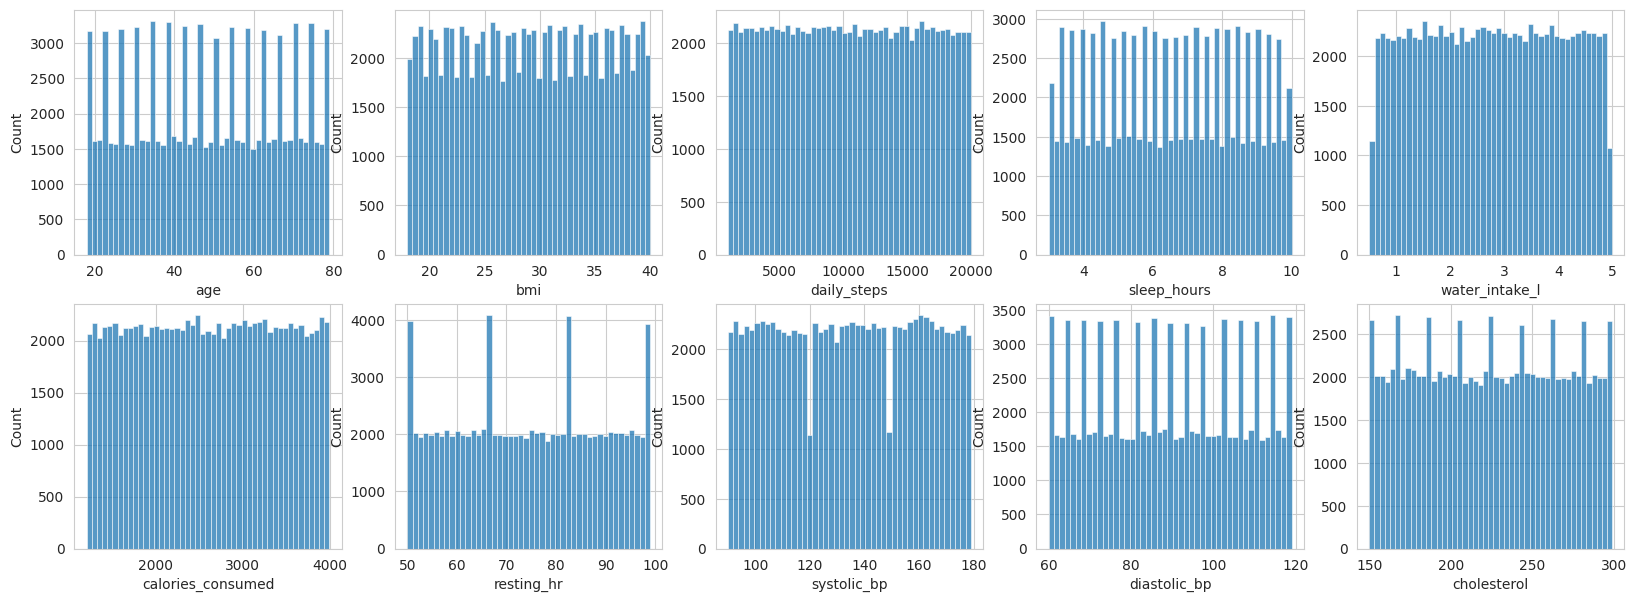

In [8]:
fig, axs = plt.subplots(2,5, figsize=(20,7))

for i, ax in enumerate(axs.flat):
  sns.histplot(x=data[other_fill[i]], palette =  'magma', ax = ax)

plt.show()

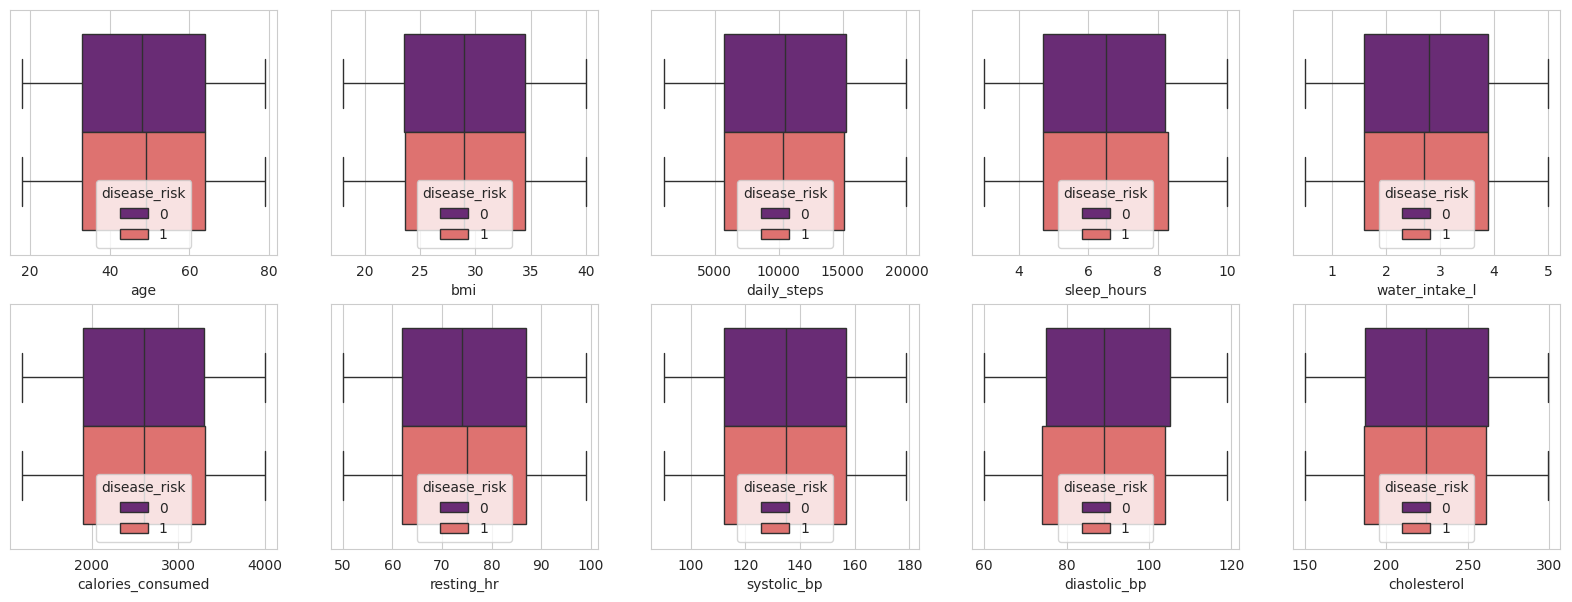

In [9]:
fig, axs = plt.subplots(2,5, figsize=(20,7))

for i, ax in enumerate(axs.flat):
  sns.boxplot(x=data[other_fill[i]], hue=data['disease_risk'],  palette =  'magma', ax = ax)

plt.show()

In [10]:
def drop_columns(X, cols):
  X = X.copy()
  X = X.drop(cols, axis=1)

  return X

In [11]:
def gen_new_columns(X):
  X = X.copy()

  X['calories_on_BMIactiv'] = X['calories_consumed'] / (X['daily_steps'] + X['bmi'])
  X['calories_on_BMIactiv'] = np.log1p(X['calories_on_BMIactiv'])

  X['sleep_effect'] = (X['sleep_hours']  * 500 )/ X['daily_steps']
  X['sleep_effect'] = np.log1p(X['sleep_effect'])


  #X['health_index'] = np.log1p( 1 + ( X['age']*(X[['smoker', 'alcohol']].sum(axis=1))* X[['calories_consumed', 'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol']].sum(axis=1))/(1 + X[['age','bmi', 'daily_steps', 'sleep_hours']].sum(axis=1)))

  return X

In [12]:
def change_dtypes(X):
  X = X.copy()
  cols = ['smoker', 'family_history', 'gender', 'alcohol']
  X[cols] = X[cols].astype(np.bool)

  return X


In [13]:
bin_fill = [ 'smoker', 'family_history', 'gender', 'alcohol']
other_fill = [col for col in data.columns if col not in bin_fill+['disease_risk', 'id', 'calories_consumed', 'sleep_hours', 'daily_steps']]

In [14]:
drop_trans = FunctionTransformer(drop_columns,
                                 kw_args={'cols' : ['id', 'calories_consumed', 'sleep_hours', 'daily_steps']},
                                 validate=False
                                )


gen_trans = FunctionTransformer(gen_new_columns,
                                validate=False)

imput_trans = ColumnTransformer(transformers=[
    ('bin_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1), bin_fill),
    ('cont_imputer', SimpleImputer(missing_values=np.nan, strategy='median'), other_fill)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False).set_output(transform='pandas')

sclaer_trans = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), other_fill)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False).set_output(transform='pandas')


preprocessing = Pipeline(steps=[
    ('imputers', imput_trans),
    ('add', gen_trans),
    ('drop', drop_trans),
    ('scaler', sclaer_trans),
])
preprocessing.set_output(transform='pandas')



Pipeline(steps=[('imputers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin_imputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='constant'),
                                                  ['smoker', 'family_history',
                                                   'gender', 'alcohol']),
                                                 ('cont_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['age', 'bmi',
                                                   'water_intake_l',
                                                   'resting_hr', 'systolic_bp',
                                                   'diastolic_bp',
                                                   'cholesterol'])],
                                   verbose_feature_...
                 FunctionTransformer(func=<function drop_columns at 0x7ae154b77920>,
                                     kw_args={'cols': ['id',
                                                       'calories_consumed',
                                                       'sleep_hours',
                                                       'daily_steps']})),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'water_intake_l',
                                                   'resting_hr', 'systolic_bp',
                                                   'diastolic_bp',
                                                   'cholesterol'])],
                                   verbose_feature_names_out=False))])

In [15]:
X = data.drop(columns=['disease_risk'])
y = data['disease_risk']

In [16]:
X = preprocessing.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=42)

In [ ]:
mi_score = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_score_series = pd.Series(mi_score, name='MI', index=X.columns)
not_null_mi_col = mi_score_series[mi_score_series > .001].index

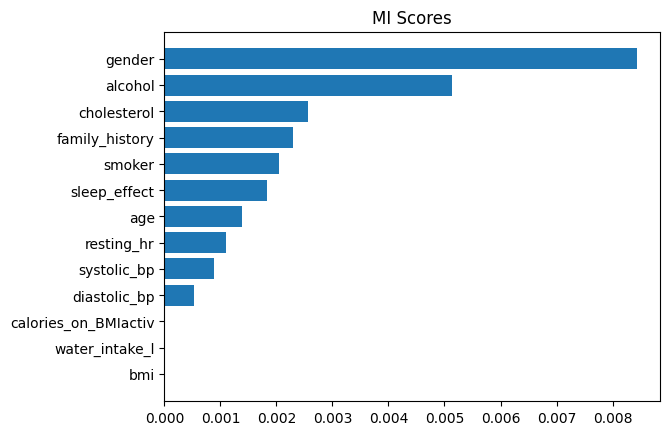

In [ ]:
plot_mi_scores(mi_score_series)

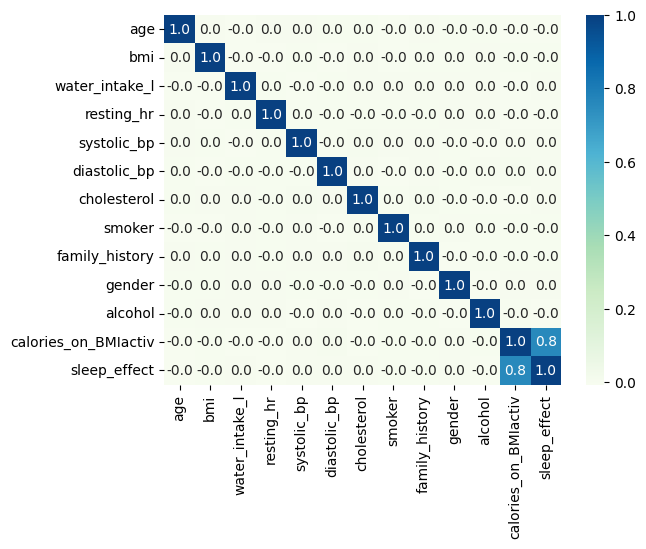

In [ ]:
sns.heatmap(X.corr(method='spearman'), annot=True, cmap='GnBu', fmt='.1f')
plt.show()

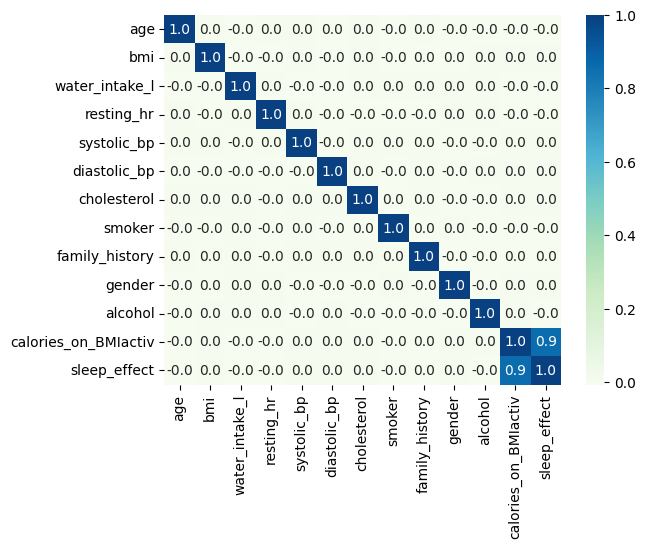

In [ ]:
sns.heatmap(X.corr(), annot=True, cmap='GnBu', fmt='.1f')
plt.show()

In [ ]:
model = LogisticRegression(penalty='l1',
                           max_iter=150,
                           class_weight='balanced',
                           solver='saga',
                           random_state=42,
                           C=0.6,
                           verbose=False)

smote = SMOTE(k_neighbors=10,
              sampling_strategy='minority',
              random_state=42)

model_pipeline = Pipeline(steps=[
    ('smote', smote),
    ('lr', model)
])

scv = StratifiedKFold(shuffle=True,
                      random_state=42)


"grid = {\n    'lr__C': [.6, .65, .7] ,\n    'lr__max_iter' : [150, 175, 200]\n}\n\ngs = GridSearchCV(model_pipeline,\n                  grid,\n                  cv=scv,\n                  scoring='f1',\n                  n_jobs=-1)"

In [ ]:
ans = cross_val_score(model_pipeline,
                      X_train[not_null_mi_col], y_train,
                      cv=scv,
                      scoring='f1')
print(np.mean(ans))

0.34744774357014274


In [ ]:
model_pipeline.fit(X_train[not_null_mi_col], y_train)

Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=10, random_state=42,
                       sampling_strategy='minority')),
                ('lr',
                 LogisticRegression(C=0.6, class_weight='balanced',
                                    max_iter=150, penalty='l1', random_state=42,
                                    solver='saga', verbose=False))])

In [ ]:
y_pred = model_pipeline.predict(X_test[not_null_mi_col])
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.75749   0.45413   0.56783     15042
           1    0.25232   0.55889   0.34768      4958

    accuracy                        0.48010     20000
   macro avg    0.50490   0.50651   0.45775     20000
weighted avg    0.63226   0.48010   0.51325     20000



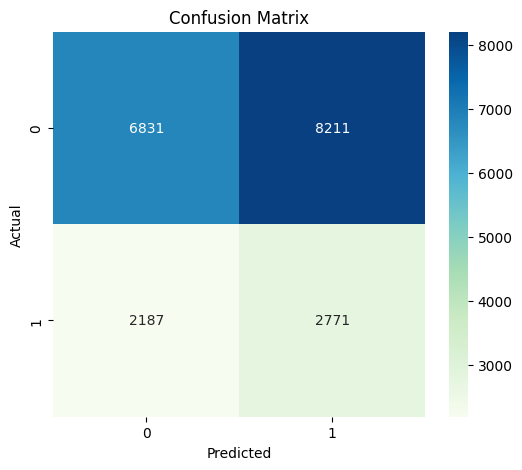

In [ ]:
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',  cmap='GnBu',)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
s = pd.Series(model_pipeline['lr'].coef_[0], index = model_pipeline['lr'].feature_names_in_)

In [ ]:
s.sort_values(ascending=False)

,0
resting_hr,0.020907
smoker,0.006915
age,0.006607
gender,0.006446
family_history,0.006378
alcohol,0.000000
cholesterol,-0.011986
sleep_effect,-0.131229
